# Importaciones

In [1]:
"""
Full demo script exercising all components of the Trading Environment repo.
"""
import logging
import optuna
from optuna.logging import set_verbosity, ERROR
import numpy as np

from trading_environment import (
    DataManager, RiskManager, PerformanceAnalyzer, Optimizer,
    ReportManager, TradingSystem, StrategyManager, StrategyCollection,
    DATA_DIR, MAX_FILE_SIZE
)
from strategies import (
    MovingAverageCrossStrategy, DcaStrategy, DonchianBreakoutStrategy,
    ADXTrendStrategy, ROCStrategy, MACDStrategy, BollingerMeanRevStrategy,
    RSIStrategy, PairTradingStrategy, VWAPStrategy
)



d:\Desktop\Algorithmic Trading\Prueba\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Strategies

In [2]:
# Suppress less important logs
logging.getLogger().setLevel(logging.ERROR)  # hide WARNING and INFO logs
set_verbosity(ERROR)  # hide Optuna warnings

In [3]:
# 1) Load data
dm = DataManager(DATA_DIR, MAX_FILE_SIZE)
data = dm.load_data(symbols='BTC-USD', period='1mo', interval='1d')
print("Data loaded shape:", data.shape)

Data loaded shape: (32, 6)


In [4]:
# 2) RiskManager Demo
price = data['close'].iloc[-1]
rm_pct = RiskManager(method='pct', risk_pct=0.02)
print("Pct size:", rm_pct.calculate_size(10000, price, data))
rm_atr = RiskManager(method='atr', risk_pct=0.01, atr_window=14)
print("ATR size:", rm_atr.calculate_size(10000, price, data, stop_loss=price*0.95))


Pct size: 0.0018705382912340438
ATR size: 0.01870538291234044


In [5]:
# 3) Strategy Demo
strat = MovingAverageCrossStrategy({'short_window':10, 'long_window':20})
sig = strat.generate_signals(data)
print("Signal counts:", sig.value_counts().to_dict())
eq = strat.backtest(data, initial_capital=10000, transaction_cost=0.001)
pa = PerformanceAnalyzer(eq, strat.returns)
print("MA Crossover Performance:\n", pa.summary())

Signal counts: {0: 31, -1: 1}
MA Crossover Performance:
 Total Return     0.008176
Ann. Return      0.066222
Ann. Vol         0.026017
Sharpe           2.477439
Max Drawdown    -0.001000
Win Rate         0.031250
Profit Factor    9.184874
Expectancy      -0.000682
dtype: float64


In [6]:

# 4) Optimizer Demo (Grid, Bayes, DE)
print("\n=== Optimizer Demo ===")
subset = [MovingAverageCrossStrategy, MACDStrategy]
# Grid Search
print("-- Grid Search --")
best_strat_g, best_params_g, perf_g, eq_g = Optimizer.find_best_strategy(
    subset, data, method='grid', metric='Sharpe'
)
print(f"Grid best: {best_strat_g.name} {best_params_g}")
# Bayesian Search
print("-- Bayesian Search --")
best_strat_b, best_params_b, perf_b, eq_b = Optimizer.find_best_strategy(
    subset, data, method='bayes', metric='Sharpe', n_trials=10, seed=123
)
print(f"Bayes best: {best_strat_b.name} {best_params_b}")
# Differential Evolution
print("-- DE Search --")
best_strat_d, best_params_d, perf_d, eq_d = Optimizer.find_best_strategy(
    subset, data, method='de', metric='Sharpe', maxiter=5, popsize=5
)
print(f"DE best: {best_strat_d.name} {best_params_d}")


=== Optimizer Demo ===
-- Grid Search --
Grid best: MACD 19/20/10 {'fast': 19, 'slow': 20, 'signal': 10}
-- Bayesian Search --
Bayes best: MACD 16/40/10 {'fast': 16, 'slow': 40, 'signal': 10}
-- DE Search --
DE best: MA 28/73 {'short_window': 28, 'long_window': 73}


Plotting metrics for Grid best...


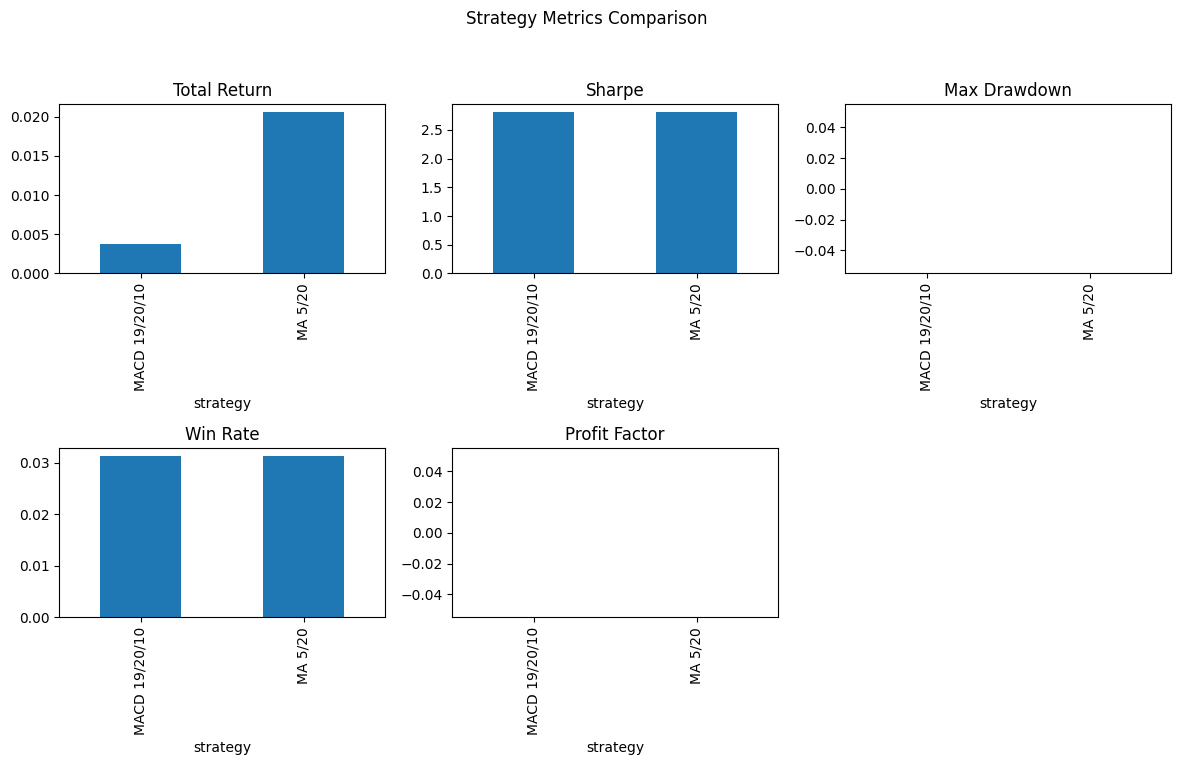

Overlaying equity curves...


AttributeError: 'dict' object has no attribute 'index'

<Figure size 1000x500 with 0 Axes>

In [7]:
# 5) ReportManager plotting & saving
rm = ReportManager()
print("Plotting metrics for Grid best...")
rm.plot_metrics(perf_g)
print("Overlaying equity curves...")
rm.plot_equity_curves({
    'Grid': eq_g,
    'Bayes': eq_b,
    'DE': eq_d
})
# Compare and save
analyzers = {
    'Grid': PerformanceAnalyzer(eq_g, eq_g.pct_change().fillna(0)),
    'Bayes': PerformanceAnalyzer(eq_b, eq_b.pct_change().fillna(0)),
    'DE': PerformanceAnalyzer(eq_d, eq_d.pct_change().fillna(0))
}
comp = rm.compare_performance(analyzers, save=True, report_name='full_demo_comparison')
print(comp)

In [ ]:

# 6) TradingSystem Demo
print("\n=== TradingSystem Demo ===")
ts = TradingSystem('BTC-USD', DcaStrategy({'amount':500,'freq':'D'}), risk_manager=RiskManager('fixed', fixed_size=1))
ts.load(period='1mo', interval='1d')
eq_ts = ts.run_backtest(save_report=True, do_print=True, report_name='ts_demo')
print(f"Final TS equity: {eq_ts.iloc[-1]:.2f}")


In [ ]:

# 7) StrategyCollection Demo
grid_params = {'short_window': [5,10], 'long_window': [20,50]}
collection = StrategyCollection(strategy_cls=MovingAverageCrossStrategy, param_grid=grid_params)
eqs = collection.backtest_all('BTC-USD', period='1mo', interval='1d')
print("Collection demos backtested strategies:", list(eqs.keys()))

In [ ]:

# 8) StrategyManager Demo
sm = StrategyManager()
strat_sample = MACDStrategy({'fast':12,'slow':26,'signal':9})
sm.save(strat_sample)
loaded = sm.load(strat_sample.name)
print("Loaded sample strategy:", loaded.name)


# FIN